In [ ]:
# === CONFIGURATION ===
import pandas as pd

# File path to the CSV data (modify here for reuse)
CSV_FILE_PATH = "/content/qna_df.csv"

# Load the data
df = pd.read_csv(CSV_FILE_PATH)

# Display basic info
print("Data loaded. Shape:", df.shape)
df.head()


Data loaded. Shape: (1106, 8)


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [ ]:
# === ROLE NORMALIZATION ===
# Standardize role names to categories like 'CEO', 'CFO', 'Analyst', 'Other'

def normalize_role(role):
    role = str(role).lower()
    if "ceo" in role:
        return "CEO"
    elif "chief executive" in role:
        return "CEO"
    elif "cfo" in role or "chief financial" in role:
        return "CFO"
    elif "analyst" in role:
        return "Analyst"
    else:
        return "Other"

df["cleaned_role"] = df["role"].apply(normalize_role)
df["cleaned_role"].value_counts()


,count
cleaned_role,
Analyst,501
CFO,356
CEO,228
Other,21


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from matplotlib_venn import venn2
from collections import Counter


# Function to load a CSV file into a pandas DataFrame
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns.")
    return df

# Summarizes missing data by count and percentage
def summarize_missing(df):
    missing_summary = df.isnull().sum().to_frame('Missing Count')
    missing_summary['Missing %'] = (df.isnull().mean() * 100).round(2)
    print("Missing Data Summary:")
    print(missing_summary)
    return missing_summary

# Adds a column with word count for each row of text in 'content'
def add_word_counts(df):
    df['word_count'] = df['content'].str.split().apply(len)
    return df

# Simplifies and standardizes speaker roles
def simplify_role(role):
    if isinstance(role, str):
        role = role.lower()
        if "chief executive" in role:
            return "CEO"
        elif "chief financial" in role:
            return "CFO"
        elif "analyst" in role:
            return "Analyst"
        elif "investor relations" in role:
            return "IR"
        elif "chairman" in role:
            return "Chairman"
        elif "president" in role:
            return "President"
        elif "chief operating" in role:
            return "COO"
        else:
            return "Other"
    return "Unknown"

# Prepares the data with cleaning, word counts, role simplification, and quarter labels
def prepare_data(df):
    df = df.dropna(subset=['content']).copy()
    df['cleaned_words'] = df['content'].apply(lambda x: re.findall(r'\b\w+\b', x.lower()))
    df = add_word_counts(df)
    df['role_simple'] = df['role'].apply(simplify_role)
    df['speaker_with_role'] = df['speaker'] + " (" + df['role_simple'].astype(str) + ")"
    df['quarter_str'] = 'Q' + df['quarter'].astype(str) + ' ' + df['year'].astype(str)
    df['quarter_year'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)
    return df

# Plots top 10 speakers by total word count and number of speaking turns
def plot_top_speakers(df):
    top_word_counts = df.groupby('speaker_with_role')['word_count'].sum().sort_values(ascending=False).head(10)
    top_turn_counts = df['speaker_with_role'].value_counts().head(10)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    top_word_counts.plot(kind='bar', color='skyblue')
    plt.title('Top 10 Speakers by Total Word Count')
    plt.ylabel('Total Words Spoken')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    top_turn_counts.plot(kind='bar', color='salmon')
    plt.title('Top 10 Speakers by Number of Speaking Turns')
    plt.ylabel('Number of Turns')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Plots total word count grouped by speaker role
def plot_word_count_by_role(df):
    word_count_by_role = df.groupby('role_simple')['word_count'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=word_count_by_role.values, y=word_count_by_role.index, palette="Blues_d")
    plt.xlabel("Total Words")
    plt.ylabel("Role")
    plt.title("Total Word Count by Role")
    plt.tight_layout()
    plt.show()

# Plots word count trends across all quarters
def plot_word_count_by_quarter(df):
    word_count_by_quarter = df.groupby('quarter_str')['word_count'].sum()
    word_count_by_quarter.plot(kind='bar', figsize=(12, 6), title='Total Word Count by Quarter')
    plt.ylabel("Total Word Count")
    plt.xlabel("Quarter")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plots the top 10 speakers by quarter-year using Seaborn FacetGrid
def plot_top_speakers_per_quarter(df):
    turns = df.groupby(['year', 'quarter', 'speaker_with_role']).size().reset_index(name='turns')
    turns['quarter_year'] = turns['year'].astype(str) + ' Q' + turns['quarter'].astype(str)
    top10 = turns.groupby('quarter_year').apply(lambda x: x.nlargest(10, 'turns')).reset_index(drop=True)

    g = sns.catplot(
        data=top10,
        x='turns',
        y='speaker_with_role',
        col='quarter_year',
        kind='bar',
        col_wrap=2,
        height=4,
        aspect=1.5,
        sharex=False
    )
    g.set_titles("Top 10 Speakers - {col_name}")
    g.set_axis_labels("Speaking Turns", "")
    plt.tight_layout()
    plt.show()

# Creates a heatmap of Jaccard similarity for vocabulary used by top 5 speakers
def plot_vocab_overlap_heatmap(df):
    top_speakers = df['speaker_with_role'].value_counts().head(5).index.tolist()
    speaker_vocab = {
        speaker: set(' '.join(df[df['speaker_with_role'] == speaker]['content']).split())
        for speaker in top_speakers
    }

    overlap_matrix = pd.DataFrame(index=top_speakers, columns=top_speakers)
    for s1 in top_speakers:
        for s2 in top_speakers:
            intersection = speaker_vocab[s1].intersection(speaker_vocab[s2])
            union = speaker_vocab[s1].union(speaker_vocab[s2])
            overlap = len(intersection) / len(union)
            overlap_matrix.loc[s1, s2] = round(overlap, 2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix.astype(float), annot=True, cmap='Blues', fmt=".2f")
    plt.title("Vocabulary Overlap (Jaccard Similarity) - Top 5 Speakers")
    plt.tight_layout()
    plt.show()

# Generates Venn diagrams comparing vocabulary overlap for each pair of top 5 speakers
def plot_venn_diagrams(df):
    top5_speakers = df['speaker_with_role'].value_counts().head(5).index.tolist()
    speaker_vocab = {
        speaker: set(' '.join(df[df['speaker_with_role'] == speaker]['content']).split())
        for speaker in top5_speakers
    }

    pairs = list(combinations(top5_speakers, 2))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
    for ax, (s1, s2) in zip(axes.flatten(), pairs):
        set1, set2 = speaker_vocab[s1], speaker_vocab[s2]
        venn2([set1, set2], set_labels=(s1, s2), ax=ax)
        ax.set_title(f"Venn Diagram: {s1} vs {s2}")
    plt.tight_layout()
    plt.show()

Data loaded: 1106 rows, 8 columns.
Missing Data Summary:
                          Missing Count  Missing %
question_order                        0        0.0
question_answer_group_id              0        0.0
speaker                               0        0.0
role                                  0        0.0
company                               0        0.0
content                               0        0.0
year                                  0        0.0
quarter                               0        0.0


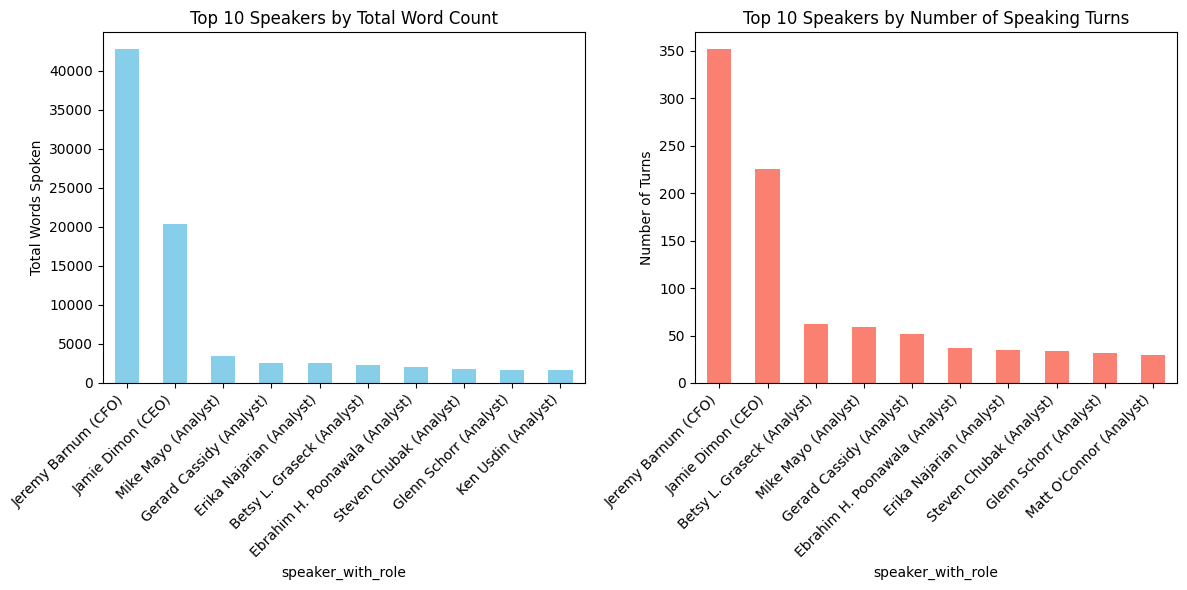

<ipython-input-3-5657e8afe840>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_count_by_role.values, y=word_count_by_role.index, palette="Blues_d")


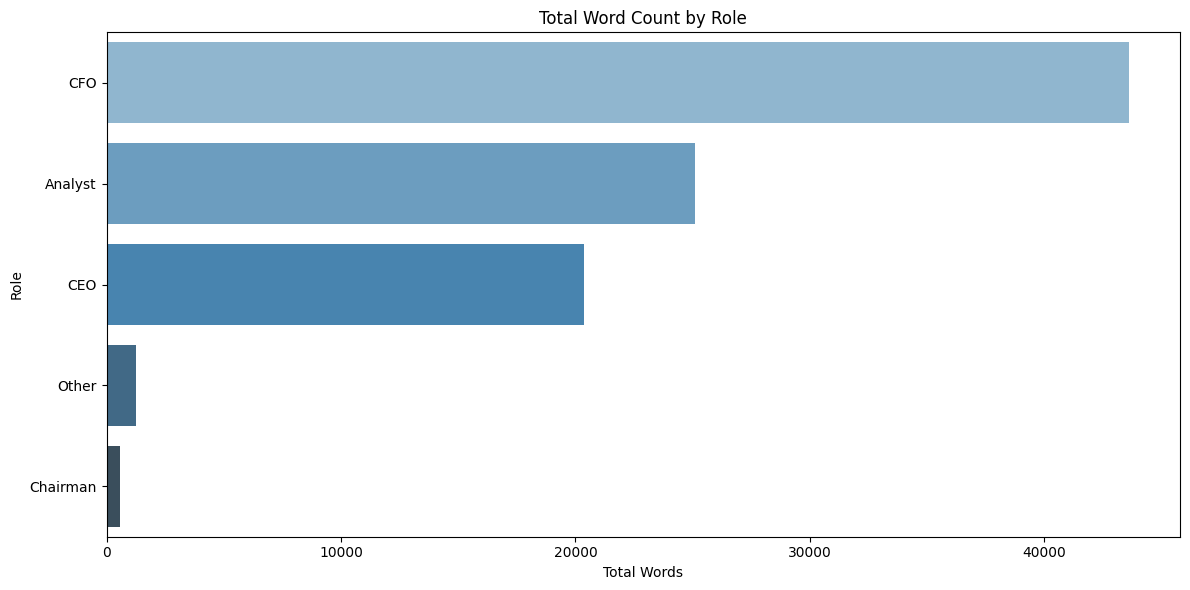

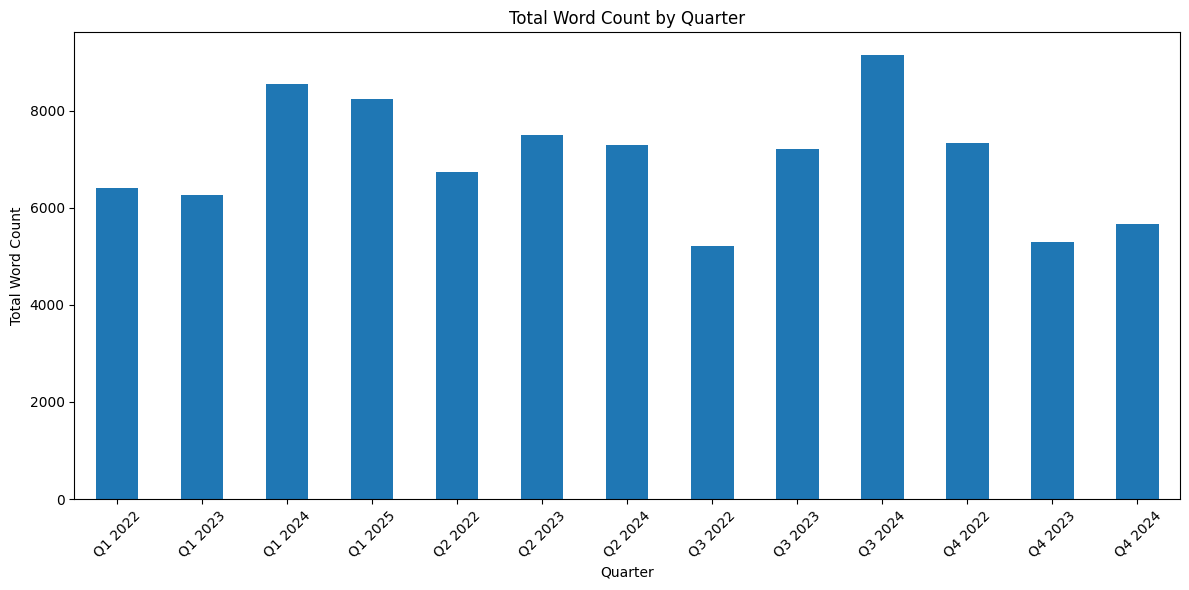

<ipython-input-3-5657e8afe840>:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10 = turns.groupby('quarter_year').apply(lambda x: x.nlargest(10, 'turns')).reset_index(drop=True)


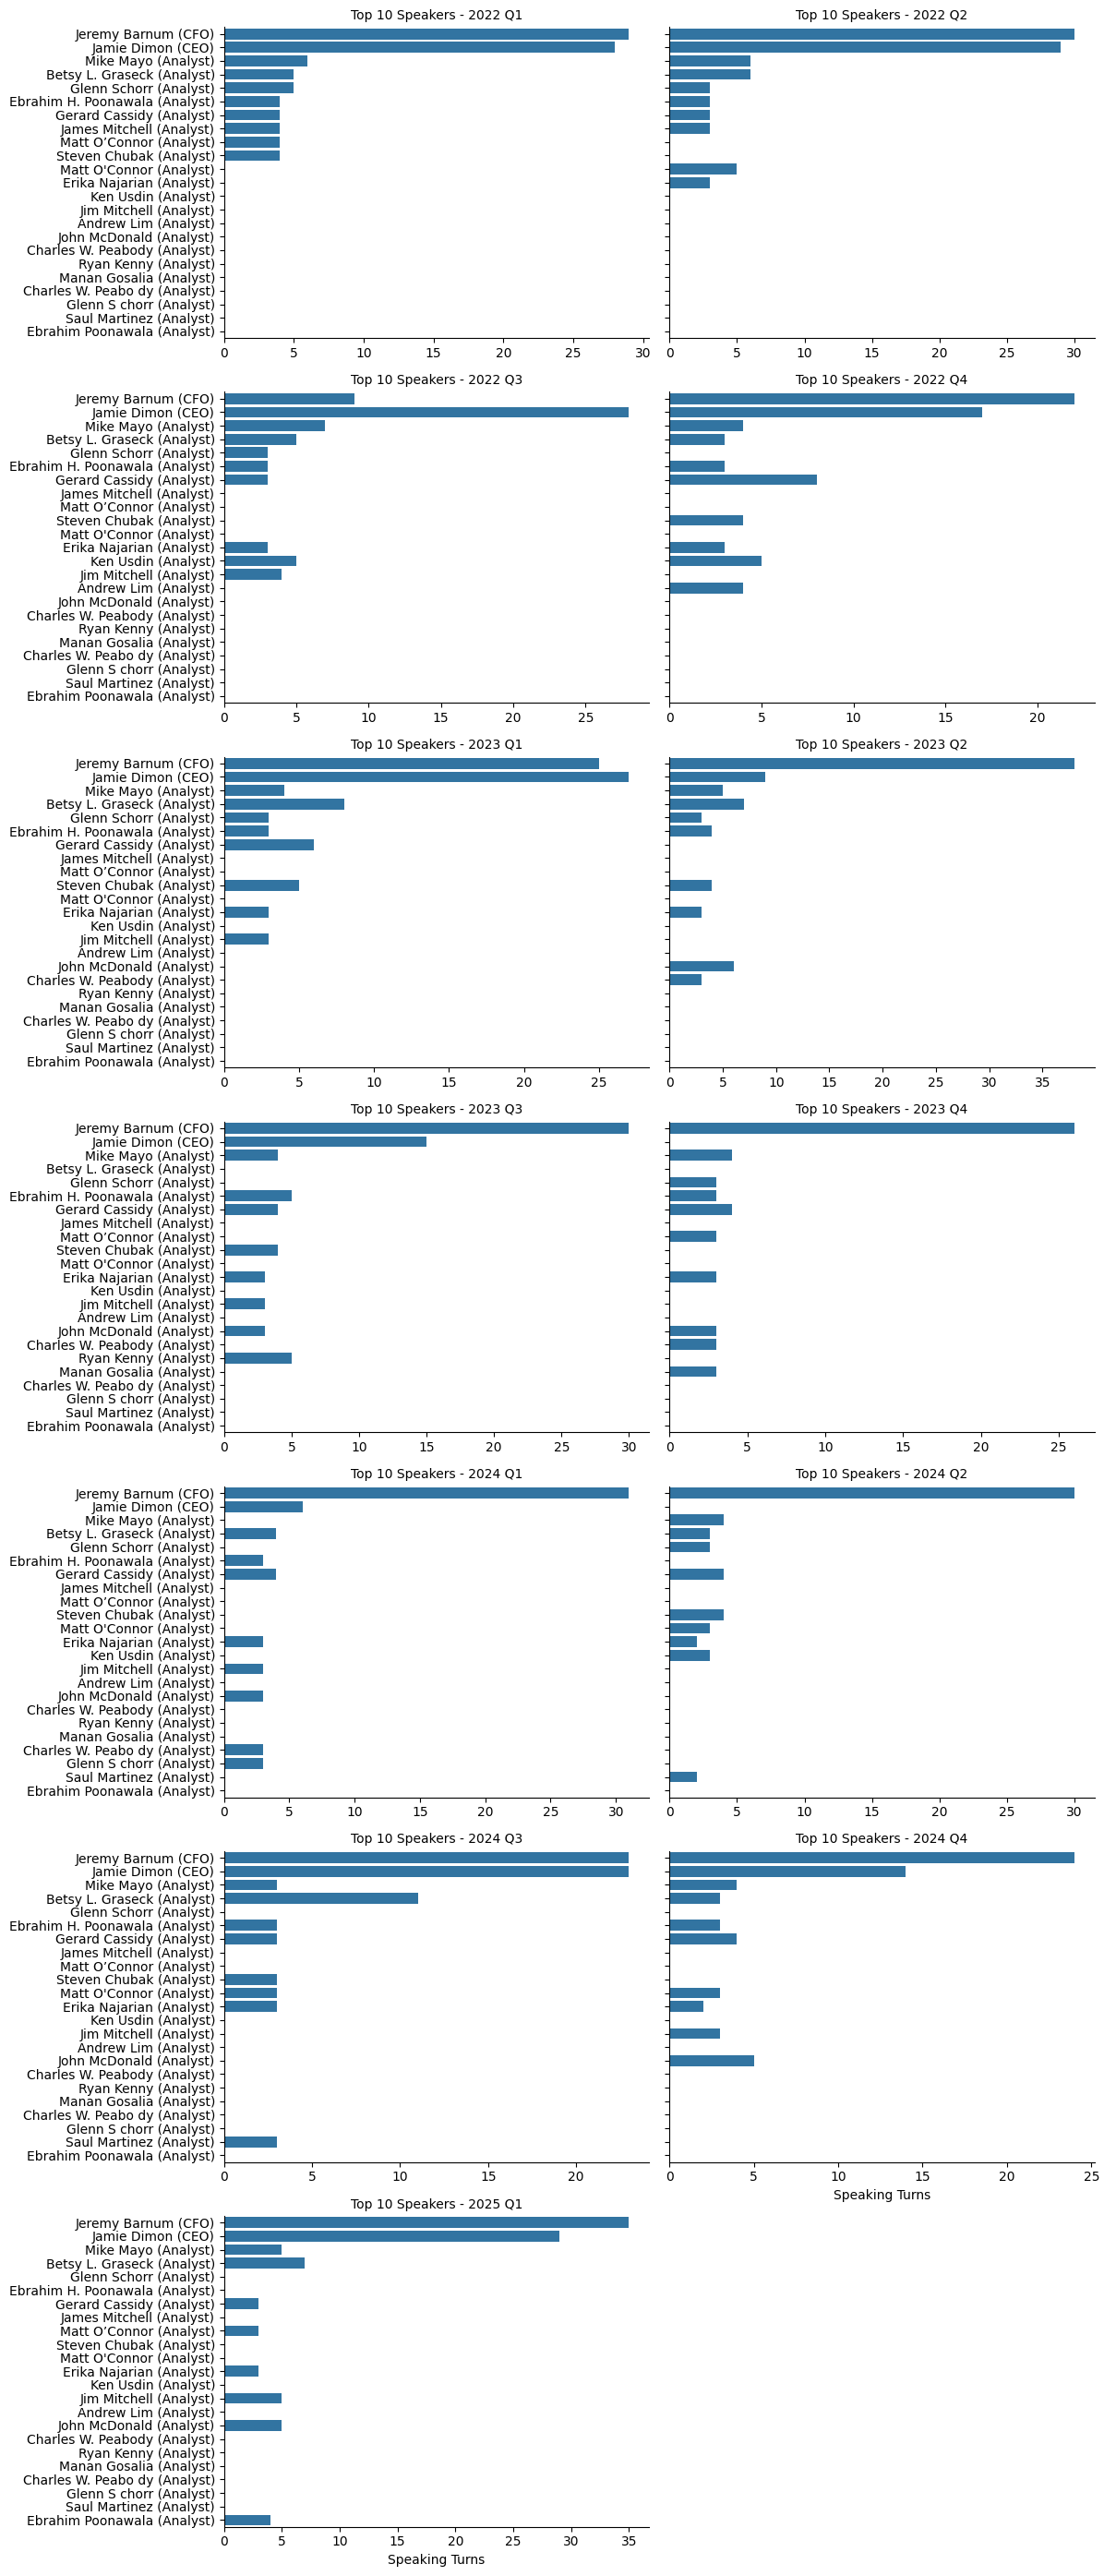

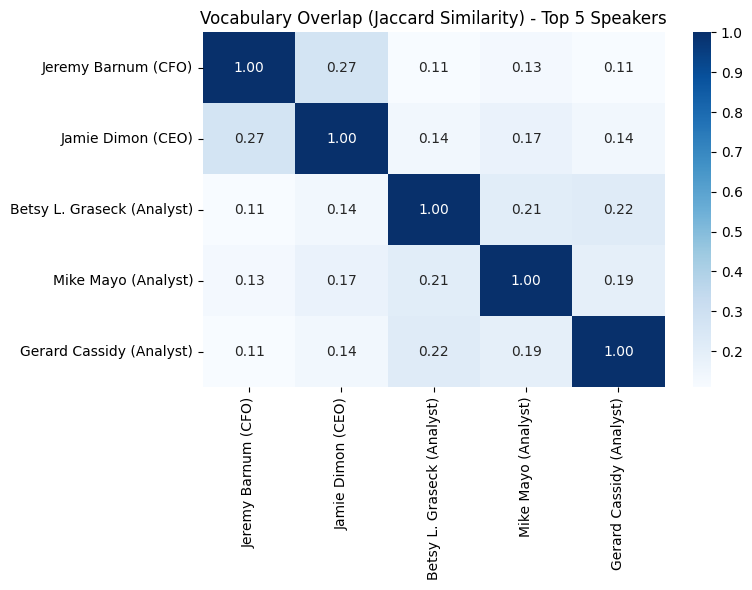

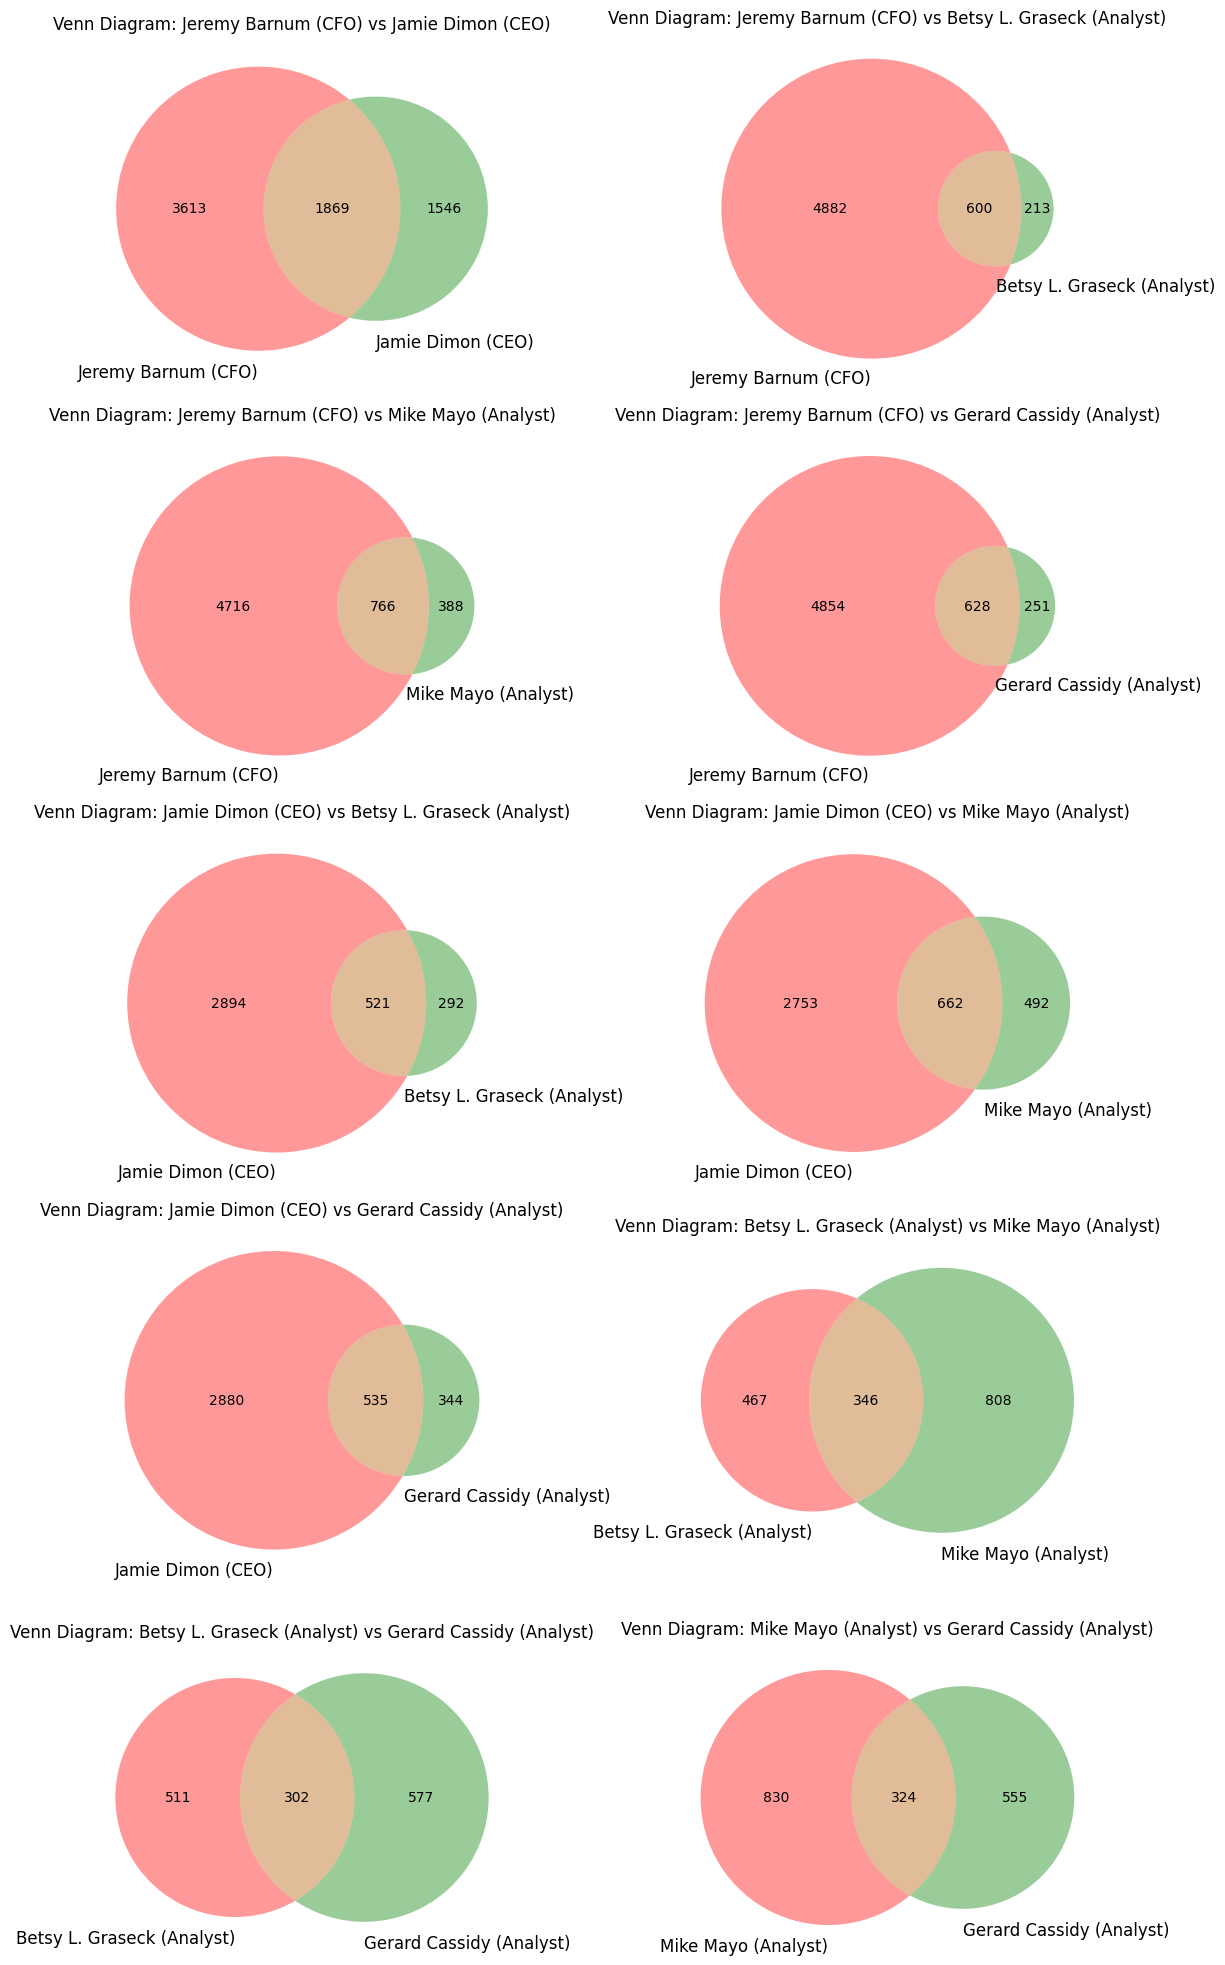

In [ ]:
# Run this section to load and visualize everything
csv_path = "/content/qna_df.csv"

df = load_data(csv_path)
summarize_missing(df)
df_clean = prepare_data(df)

plot_top_speakers(df_clean)
plot_word_count_by_role(df_clean)
plot_word_count_by_quarter(df_clean)
plot_top_speakers_per_quarter(df_clean)
plot_vocab_overlap_heatmap(df_clean)
plot_venn_diagrams(df_clean)


In [ ]:
# Apply the filter to get financial words per row
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

def filter_financial_terms(word_list):
    return [w for w in word_list if w in financial_keywords]

df_clean['financial_words'] = df_clean['cleaned_words'].apply(filter_financial_terms)

display(df_clean.head())

,question_order,question_answer_group_id,speaker,role,company,content,year,quarter,cleaned_words,word_count,role_simple,speaker_with_role,quarter_str,quarter_year,financial_words
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1,"[thank, you, morning, jeremy, was, wondering, ...",65,Analyst,John E. McDonald (Analyst),Q1 2022,2022 Q1,"[net, interest, income, net, interest, income]"
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1,"[good, morning, john, good, question, yeah, lo...",107,CFO,Jeremy Barnum (CFO),Q1 2022,2022 Q1,[credit]
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1,"[okay, and, as, my, follow, up, could, you, gi...",35,Analyst,John E. McDonald (Analyst),Q1 2022,2022 Q1,"[nii, rates]"
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1,"[yeah, i, guess, i, would, direct, you, to, my...",101,CFO,Jeremy Barnum (CFO),Q1 2022,2022 Q1,[]
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1,"[okay, thanks]",2,Analyst,John E. McDonald (Analyst),Q1 2022,2022 Q1,[]


<ipython-input-6-601c33aae33d>:2: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  role_word_lists = df_clean.groupby('role_simple')['financial_words'].apply(sum)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette`

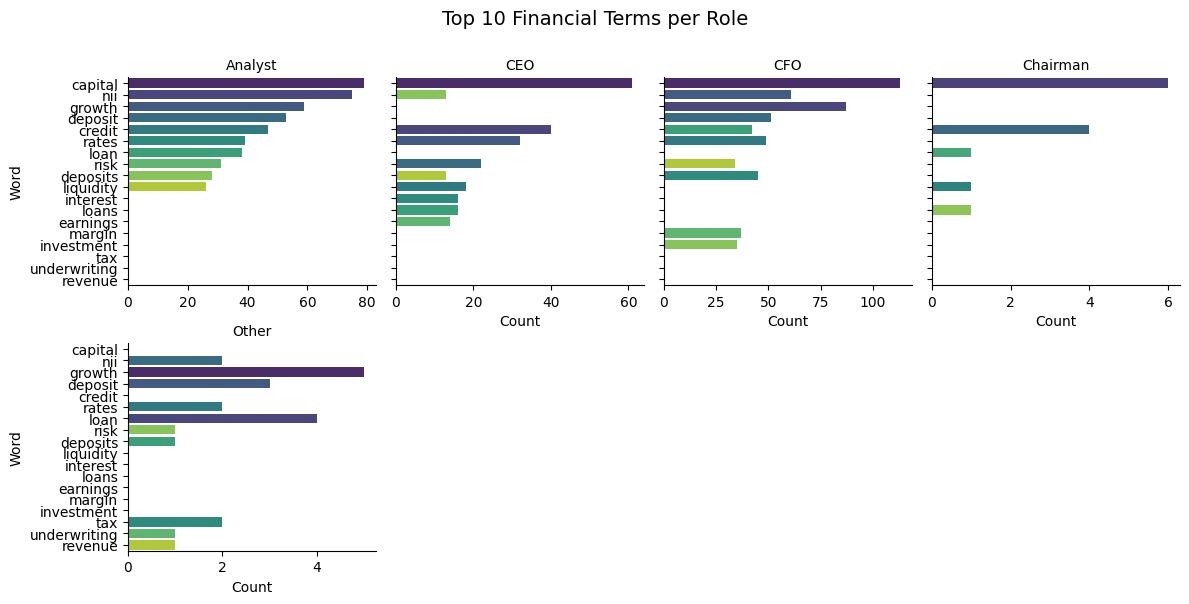

In [ ]:
# Group words by role
role_word_lists = df_clean.groupby('role_simple')['financial_words'].apply(sum)

# Top 10 words per role
top_words_by_role = {
    role: Counter(words).most_common(10)
    for role, words in role_word_lists.items()
}

# Prepare for plotting
plot_data = []
for role, words in top_words_by_role.items():
    for word, count in words:
        plot_data.append({'Role': role, 'Word': word, 'Count': count})
plot_df = pd.DataFrame(plot_data)

# Visualize
g = sns.FacetGrid(plot_df, col="Role", col_wrap=4, height=3, sharex=False)
g.map_dataframe(sns.barplot, x="Count", y="Word", palette="viridis")
g.set_titles("{col_name}")
g.set_axis_labels("Count", "Word")
g.fig.suptitle("Top 10 Financial Terms per Role", fontsize=14, y=1)
plt.tight_layout()
plt.show()

In [ ]:
# Tokenize, lowercase and extract financial words per row
import re

def extract_financial_terms(text):
    if pd.isnull(text): return []
    words = re.findall(r'\b\w+\b', text.lower())
    return [w for w in words if w in financial_keywords]

df_clean['financial_terms'] = df_clean['content'].apply(extract_financial_terms)

# Expand terms for each quarter
from collections import Counter

# Group by quarter and aggregate terms
top_financial_words_per_quarter = {}
for label, group in df_clean.groupby('quarter_year'):
    all_terms = [term for sublist in group['financial_terms'] for term in sublist]
    counter = Counter(all_terms).most_common(10)
    top_financial_words_per_quarter[label] = counter

# Display sample
import pprint
pprint.pprint(dict(list(top_financial_words_per_quarter.items())[:4]))

{'2022 Q1': [('growth', 16),
             ('capital', 15),
             ('inflation', 9),
             ('credit', 8),
             ('risk', 8),
             ('deposits', 8),
             ('income', 6),
             ('liquidity', 6),
             ('nii', 5),
             ('loan', 5)],
 '2022 Q2': [('growth', 19),
             ('capital', 16),
             ('loan', 14),
             ('risk', 13),
             ('credit', 13),
             ('rates', 12),
             ('deposits', 10),
             ('nii', 9),
             ('deposit', 8),
             ('portfolio', 6)],
 '2022 Q3': [('rates', 11),
             ('investment', 8),
             ('liquidity', 7),
             ('loan', 7),
             ('nii', 6),
             ('deposit', 6),
             ('credit', 6),
             ('capital', 5),
             ('growth', 5),
             ('loans', 5)],
 '2022 Q4': [('capital', 22),
             ('nii', 13),
             ('investment', 12),
             ('credit', 10),
             ('growth', 10

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

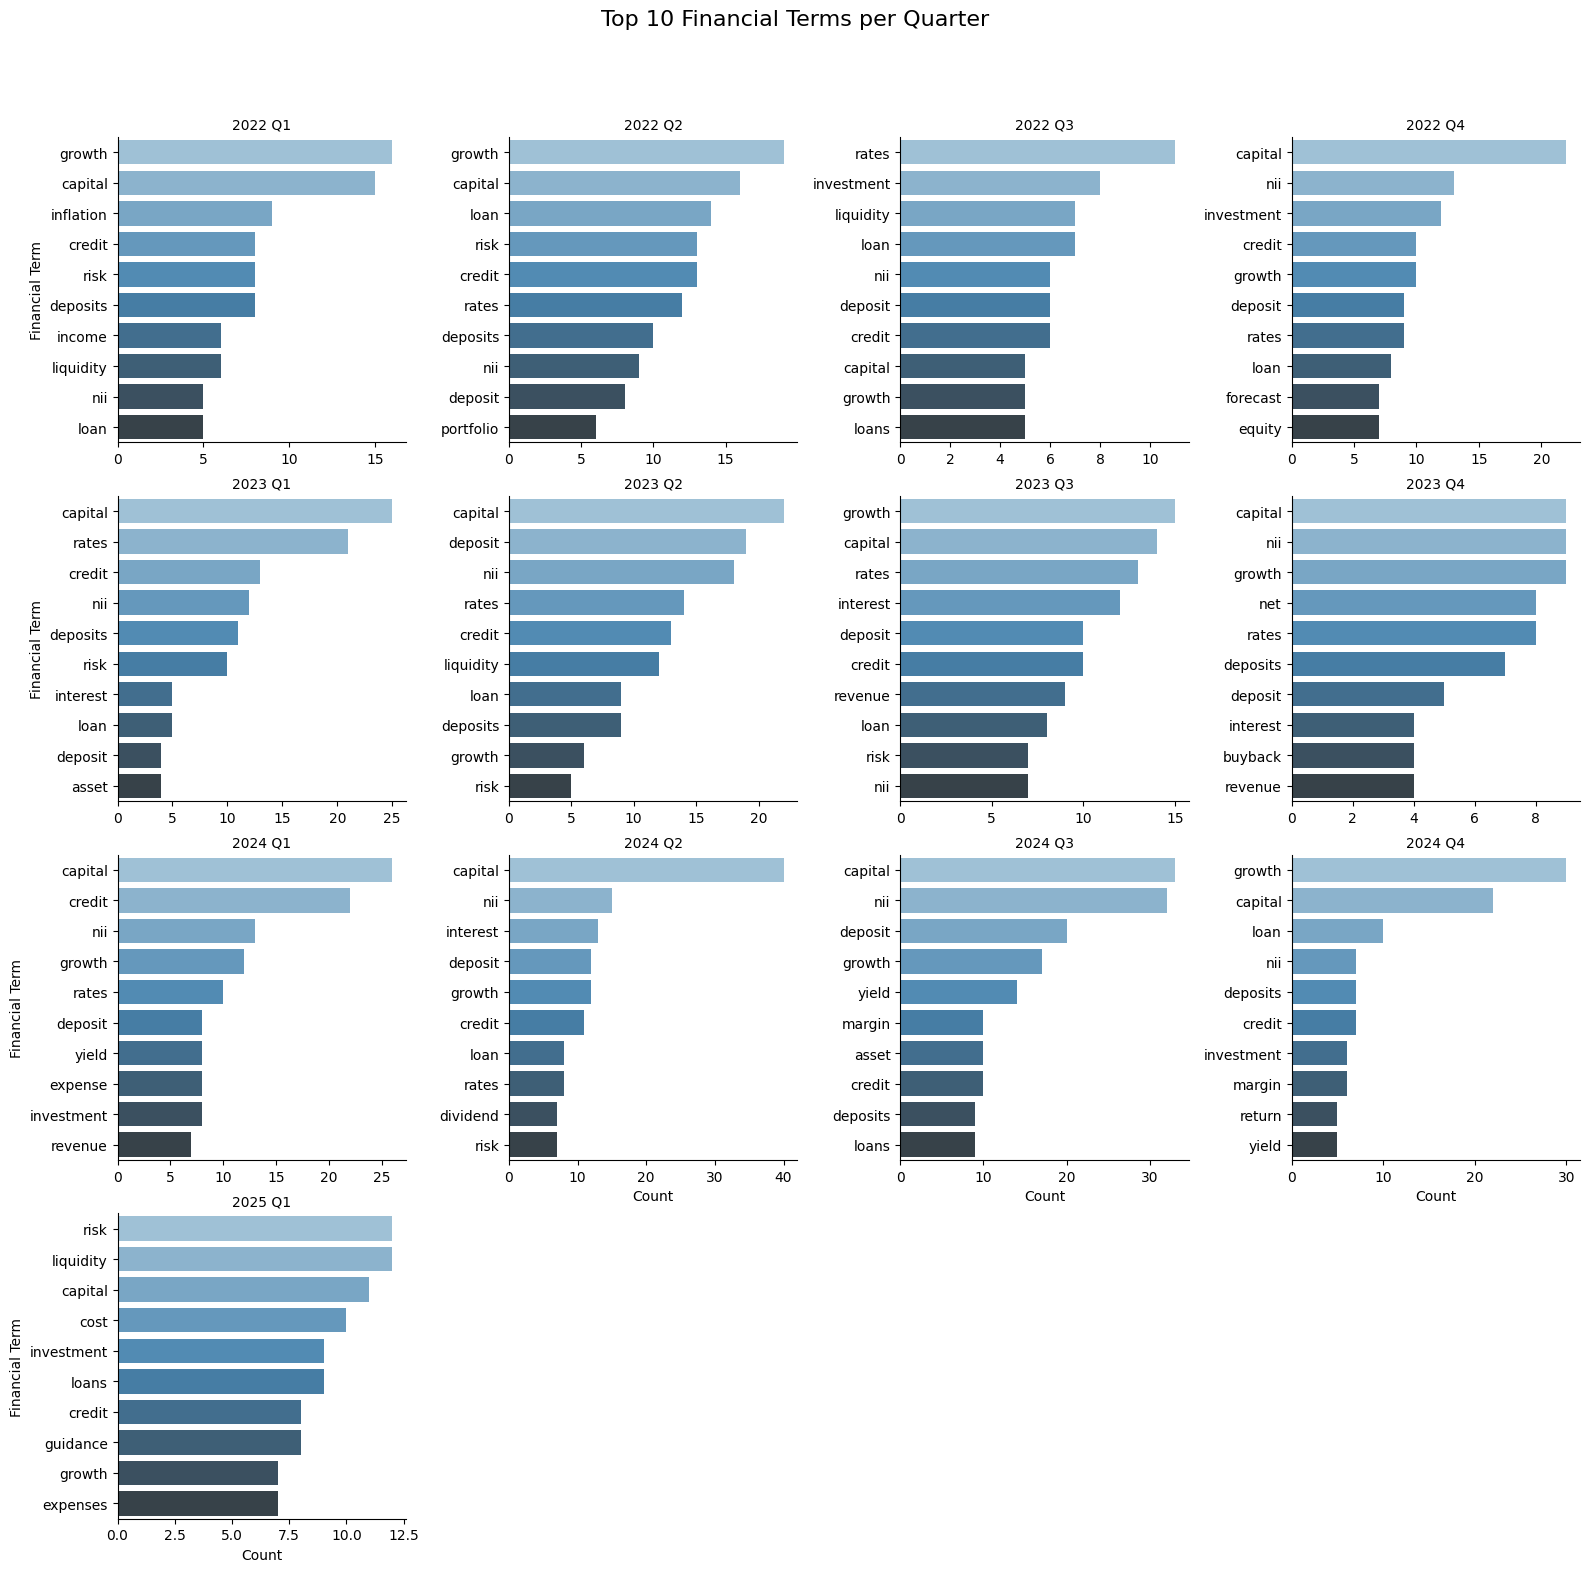

In [ ]:
# Convert the Counter dictionary into a flat DataFrame
records = []
for quarter, word_counts in top_financial_words_per_quarter.items():
    for word, count in word_counts:
        records.append({"Quarter": quarter, "Word": word, "Count": count})

top_terms_df = pd.DataFrame(records)

# Sort quarters chronologically for consistent plotting
# Add a check for the number of elements after splitting and handle potential non-integer years
def sort_key(x):
    parts = x.split('-')
    if len(parts) == 2:
        try:
            year = int(parts[1])
            quarter = parts[0]
            return (year, quarter)
        except ValueError:
            # Handle cases where the second part is not an integer
            return (0, x) # Place these at the beginning or end as needed
    else:
        # Handle cases with unexpected formats
        return (0, x) # Place these at the beginning or end as needed

quarter_order = sorted(top_terms_df['Quarter'].unique(), key=sort_key)
top_terms_df['Quarter'] = pd.Categorical(top_terms_df['Quarter'], categories=quarter_order, ordered=True)

# Plot with seaborn: Grid of barplots
g = sns.FacetGrid(top_terms_df, col="Quarter", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="Count", y="Word", palette="Blues_d")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Count", "Financial Term")
g.tight_layout()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Financial Terms per Quarter", fontsize=16)
plt.show()

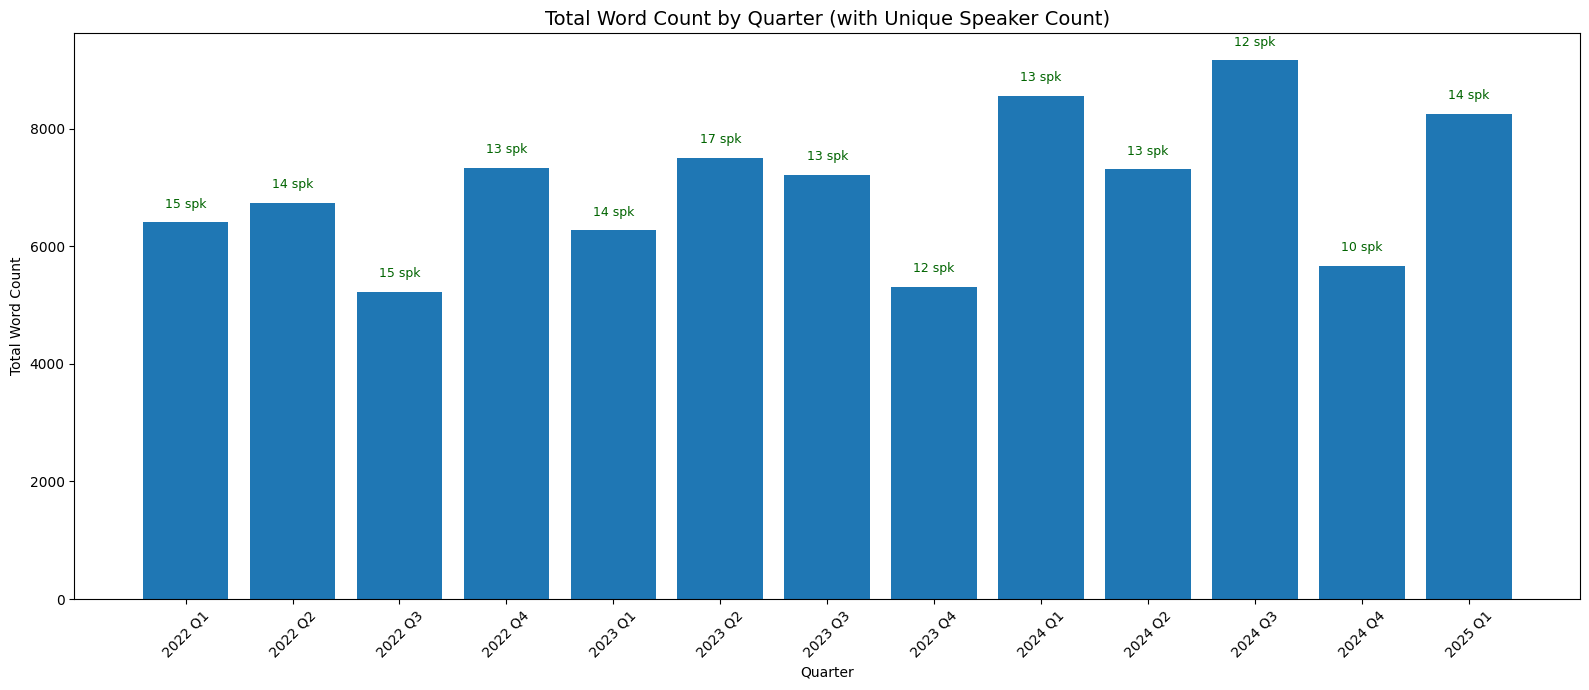

In [ ]:
# Compute total word count and unique speaker count per quarter
agg_df = df_clean.groupby('quarter_year').agg(
    total_words=('content', lambda x: x.str.split().str.len().sum()),
    unique_speakers=('speaker', pd.Series.nunique)
).reset_index()

# Sort quarter labels chronologically
agg_df = agg_df.sort_values(by='quarter_year', key=lambda col: col.map(
    lambda x: (int(x.split()[0]) if len(x.split()) > 1 else 0, x.split()[1] if len(x.split()) > 1 else x)))

# Plot the total word count
plt.figure(figsize=(16, 7))
bars = plt.bar(agg_df['quarter_year'], agg_df['total_words'])

# Add speaker count labels above each bar
for bar, count in zip(bars, agg_df['unique_speakers']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 200, f"{count} spk",
             ha='center', va='bottom', fontsize=9, color='darkgreen')

# Titles and labels
plt.title("Total Word Count by Quarter (with Unique Speaker Count)", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

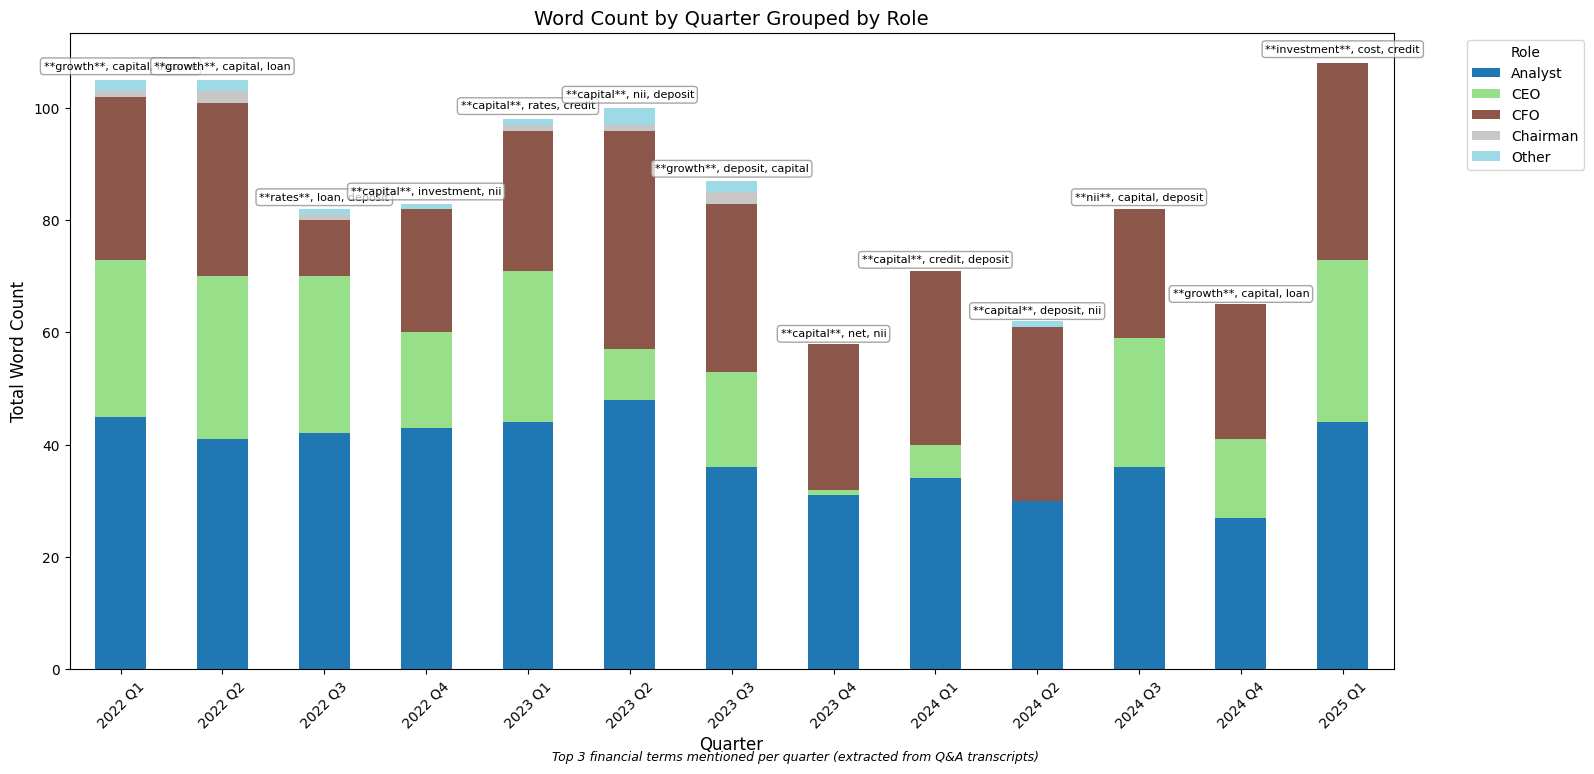

In [ ]:
# --- Define financial keywords ---
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

# --- Step 1: Build dict: quarter -> top 3 financial words ---
top_words_per_quarter = {}

# Ensure quarter_year is sorted chronologically (e.g., 2022 Q1 to 2025 Q1)
def sort_key(q):
    parts = q.split() # Split by space
    if len(parts) == 2:
        try:
            year = int(parts[0]) # Year is the first part
            quarter = parts[1] # Quarter is the second part
            return (year, quarter)
        except ValueError:
            # Handle cases where the parts are not as expected
            return (0, q) # Place these at the beginning or end as needed
    else:
        # Handle cases with unexpected formats
        return (0, q) # Place these at the beginning or end as needed

# Group by quarter and aggregate content
for quarter, group in df_clean.groupby('quarter_year'):
    words = " ".join(group["content"].dropna().astype(str)).lower().split()
    filtered_words = [w for w in words if w in financial_keywords]
    most_common = Counter(filtered_words).most_common(3)
    if most_common:
        # Bold the most frequent word
        formatted = [f"**{most_common[0][0]}**"] + [w for w, _ in most_common[1:]]
        top_words_per_quarter[quarter] = ", ".join(formatted)
    else:
        top_words_per_quarter[quarter] = ""

# --- Create the pivot table for plotting ---
# Assuming 'role_simple' and 'quarter_year' are in df_clean
pivot = df_clean.groupby(['quarter_year', 'role_simple']).size().unstack(fill_value=0)

# Sort pivot table columns (roles) alphabetically and rows (quarters) chronologically
pivot = pivot.sort_index(axis=1).sort_index(key=lambda col: col.map(sort_key))


# --- Step 2: Annotate the stacked barplot ---
ax = pivot.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='tab20')

plt.title("Word Count by Quarter Grouped by Role", fontsize=14)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Total Word Count", fontsize=12)
plt.xticks(rotation=45)

# Annotate with top words dynamically above bars
for i, quarter in enumerate(pivot.index):
    total_height = pivot.loc[quarter].sum()
    offset = total_height * 0.015  # ~1.5% of total bar height
    words = top_words_per_quarter.get(quarter, "")
    ax.text(i, total_height + offset, words, ha='center', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

# Improve layout and spacing
plt.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Give space for text boxes above bars

# Caption (optional)
plt.figtext(0.5, 0.01, "Top 3 financial terms mentioned per quarter (extracted from Q&A transcripts)",
            wrap=True, horizontalalignment='center', fontsize=9, style='italic')

plt.show()

## Key Observations:

1. By Role:

Analysts consistently dominate word count in every quarter — especially active in 2023 Q2 and 2025 Q1.

CEOs contribute moderately, with notable dips in 2023 Q4 and 2024 Q1.

CFOs show steady, high participation in most quarters — particularly in 2023 Q1–Q2 and 2025 Q1.

Chairman and Other roles have minimal word contributions.

2. Top Financial Terms (per quarter):

"Capital" is the most persistent term — appears in 10 out of 13 quarters.

"Growth" appears most in 2022 and 2024 Q4, signaling periodic emphasis.

"Deposit", "NII" (Net Interest Income), and "Credit" rise in importance during 2023–2024, aligning with macroeconomic concerns (e.g., rates, liquidity).

Recent focus in 2025 Q1 shifts to "Investment", "Cost", and "Credit", hinting at strategy or expense management.

## Interpretation:

Capital is a structural concern across roles and time — suggesting it’s a core theme in internal and investor dialogue.

Growth and investment are discussed strategically, more prominent when market conditions support them.

The role-based breakdown shows:

Analysts ask the majority of questions.

CFOs tend to respond most, indicating financial detail responsibility.

CEOs provide high-level insight intermittently.

# Summary:

This chart reflects thematic continuity in Goldman Sachs' earnings discussions:

"Capital" is ever-present.

Term focus shifts over time: from growth and loans (2022) → to deposits, credit, NII (2023–2024) → to investment and cost (2025).

The communication dynamic is driven heavily by Analysts and CFOs, showing the analytical depth and financial scrutiny in Q&A sessions.

In [ ]:
print(df.columns)


Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content', 'year', 'quarter', 'financial_terms'],
      dtype='object')


In [ ]:
from itertools import combinations
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_venn_diagrams_financial_only(df):
    financial_keywords = {
        "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
        "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
        "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
        "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
        "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
        "risk", "hedge", "investment", "investments", "buyback", "underwriting"
    }

    # Top 5 speakers by number of speaking turns
    top5_speakers = df['speaker'].value_counts().head(5).index.tolist()

    # Filter each speaker's vocabulary to financial keywords only
    speaker_vocab = {
        speaker: set(re.findall(r'\b\w+\b', ' '.join(
            df[df['speaker'] == speaker]['content'].tolist()
        ).lower())) & financial_keywords
        for speaker in top5_speakers
    }

    # Optional: Print to verify vocab
    for speaker, words in speaker_vocab.items():
        print(f"{speaker}: {sorted(words)}")

    # Generate pairwise venn diagrams
    pairs = list(combinations(top5_speakers, 2))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

    for ax, (s1, s2) in zip(axes.flatten(), pairs):
        set1, set2 = speaker_vocab[s1], speaker_vocab[s2]
        venn2([set1, set2], set_labels=(s1, s2), ax=ax)
        ax.set_title(f"Venn Diagram (Financial Words): {s1} vs {s2}")

    plt.tight_layout()
    plt.show()


Jeremy Barnum: ['asset', 'assets', 'buyback', 'capital', 'cash', 'cost', 'costs', 'credit', 'debt', 'deposit', 'deposits', 'dividend', 'earnings', 'equity', 'expense', 'expenses', 'fee', 'fees', 'forecast', 'growth', 'guidance', 'income', 'inflation', 'interest', 'investment', 'investments', 'liabilities', 'liability', 'liquidity', 'loan', 'loans', 'loss', 'margin', 'net', 'nii', 'portfolio', 'rates', 'return', 'revenue', 'risk', 'spread', 'tax', 'underwriting', 'valuation', 'yield']
Jamie Dimon: ['asset', 'assets', 'buyback', 'capital', 'cash', 'cost', 'credit', 'debt', 'deposit', 'deposits', 'dividend', 'earnings', 'equity', 'expense', 'expenses', 'forecast', 'growth', 'guidance', 'hedge', 'income', 'inflation', 'interest', 'investment', 'investments', 'liquidity', 'loan', 'loans', 'loss', 'net', 'nii', 'portfolio', 'rates', 'return', 'revenue', 'risk', 'spread', 'underwriting', 'valuation', 'yield']
Betsy L. Graseck: ['asset', 'assets', 'buyback', 'capital', 'cost', 'credit', 'depos

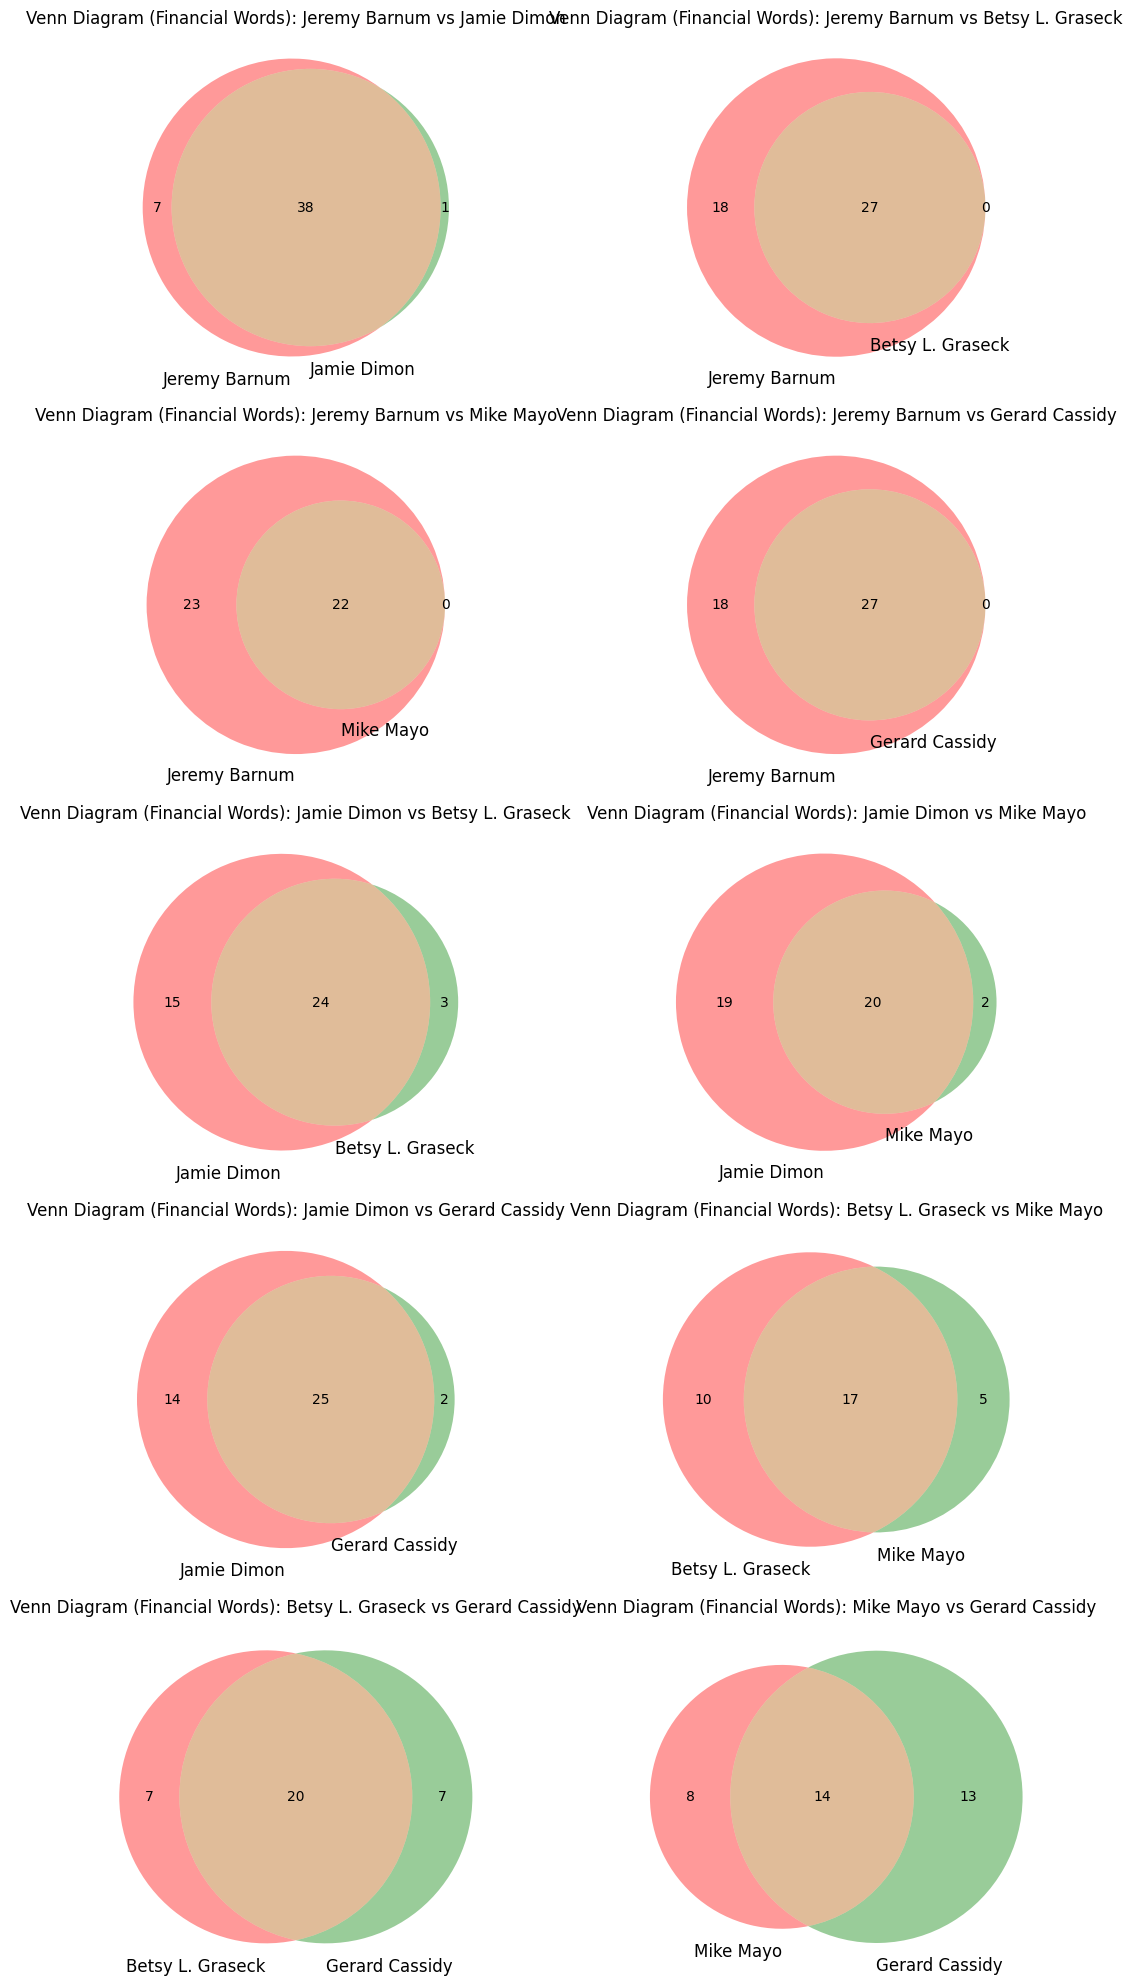

In [ ]:
plot_venn_diagrams_financial_only(df)


In [ ]:
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Use the existing df_clean DataFrame which already has 'quarter_year' and 'clean_text'

# Ensure year_quarter is in string format (already should be from df_clean creation)
df_clean['year_quarter'] = df_clean['quarter_year'].astype(str)

# Normalize text (already done in df_clean creation, but ensure lowercase)
df_clean['clean_text'] = df_clean['content'].fillna('').str.lower()

# --- Further analysis can be added here ---

In [ ]:
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

# Count keywords per quarter
trend_counts = defaultdict(lambda: Counter())

for _, row in df_clean.iterrows():
    quarter = row['year_quarter']
    words = row['clean_text'].split()
    for word in words:
        if word in financial_keywords:
            trend_counts[quarter][word] += 1

# Convert to DataFrame
trend_df = pd.DataFrame(trend_counts).fillna(0).astype(int).T.sort_index()
display(trend_df.head())

,net,interest,income,credit,capital,buyback,inflation,growth,risk,revenue,...,loans,hedge,equity,fees,expenses,return,margin,liabilities,fee,valuation
2022 Q1,3,3,6,5,10,1,5,12,6,2,...,0,0,0,0,0,0,0,0,0,0
2022 Q2,1,0,4,10,13,1,0,15,12,4,...,0,0,0,0,0,0,0,0,0,0
2022 Q3,4,0,0,4,3,1,2,5,2,3,...,4,2,0,0,0,0,0,0,0,0
2022 Q4,0,2,2,8,20,0,1,5,4,4,...,4,1,7,1,3,1,0,0,0,0
2023 Q1,1,5,1,13,18,2,2,0,8,1,...,3,0,1,0,0,1,1,0,0,0


In [ ]:
import plotly.graph_objects as go

# Calculate the total frequency of each word across all quarters
word_totals = trend_df.sum().sort_values(ascending=False)

# Get the top 10 most frequent words
top10_words = word_totals.head(10).index.tolist()

# Create an interactive figure
fig = go.Figure()

# Add a trace for each of the top 10 words
for word in top10_words:
    fig.add_trace(go.Scatter(
        x=trend_df.index.astype(str),
        y=trend_df[word],
        mode='lines+markers',
        name=word
    ))

# Customize layout
fig.update_layout(
    title="Interactive Trend of Top 10 Financial Keywords per Quarter",
    xaxis_title="Quarter",
    yaxis_title="Frequency",
    hovermode="x unified",
    legend_title="Keyword",
    height=600,
    width=1200
)

fig.show()

# Key Observations:

Dominant Themes:
Capital (blue) is the most consistently used keyword, peaking in 2024 Q2 with 32 mentions — a sharp rise aligning with strategic or regulatory capital discussions.

NII (Net Interest Income) shows spike behavior, peaking in 2024 Q3, possibly due to rate changes or interest margin concerns.

Growth, credit, and deposit are moderately mentioned throughout, showing sustained interest in business expansion and credit dynamics.

Investment and loan maintain mid-to-low frequency, implying tactical use rather than central strategic focus.

# Notable Trend Shifts:

Deposits (orange line) were more discussed early in 2022 but lost relevance post-2023.

Rates and loan usage fluctuates, suggesting reactionary discussions — likely responding to Fed rate moves or lending cycles.

A coordinated spike in capital, NII, and credit in 2023 Q2 – 2024 Q3 hints at a strategic shift or economic stress period.

## Interpretation:

"Capital" leads the narrative — indicating focus on regulatory capital buffers, CET1 ratio discussions, or capital return policies.

"NII" spikes are likely triggered by interest rate policy shifts and their impact on the bank's margin.

Topics like "risk", "investment", and "deposits" fluctuate at low frequency, pointing to their supporting but non-dominant roles in quarterly discussions.

2024 appears to be a pivotal year for capital and NII focus, possibly due to macroeconomic tightening or internal balance sheet adjustments.

## Summary:

JP Morgan’s Q&A keyword trends from 2022 to 2025 reflect a shift from deposit-growth dialogue (2022) toward a capital and NII-centric narrative (2023–2024). This transition suggests reactive strategy to economic headwinds, regulatory changes, or margin pressures.
